<a href="https://colab.research.google.com/github/mqquiroz/ICH3424/blob/master/Procesamiento_Datos_Tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
GIT_PATH = 'https://github.com/moflaher/ttide_py.git'
!git clone '{GIT_PATH}'
%cd ttide_py/
##!mv ./ttide_py/
##!rm -rf ./temp
##!ls
!python setup.py install

Cloning into 'ttide_py'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 559 (delta 16), reused 15 (delta 7), pack-reused 525
Receiving objects: 100% (559/559), 293.03 KiB | 3.57 MiB/s, done.
Resolving deltas: 100% (348/348), done.
/content/ttide_py
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:502: UserWarning: The version specified ('0.3_exp') is an invalid version, this may not work as expected with newer versions of setuptools, pip, and PyPI. Please see PEP 440 for more details.
  "details." % version
running install
running bdist_egg
running egg_info
creating ttide.egg-info
writing ttide.egg-info/PKG-INFO
writing dependency_links to ttide.egg-info/dependency_links.txt
writing top-level names to ttide.egg-info/top_level.txt
writing manifest file 'ttide.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'ttide.egg-info/SOURCES.txt'
insta

In [2]:
#Cargamos las librerias
import numpy as np
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from ttide.t_tide import t_tide
from ttide.t_tide import t_predic

In [3]:
def tide_extract(code,timestart,days=30):#timestop):#,days):
  print('Please wait, connecting to the server... \n')
  #Function to extract tide gauge data in a station from IOC level Monitoring (http://www.ioc-sealevelmonitoring.org)
  #in automatic way (Web Scrapping).
  #arguments:
  #code      : station code (extracted from IOC webpage), example: 'coqu'
  #timestart : initial time (date, UTC) of the record, examples: '2010-02-27','27/02/2010','2010-02-27 06:30','27/02/2010 06:30'  
  #days      : number of days from timestart (default value = 30 days)
  #timestop  : final time (date, UTC) of the record, example: '2010-03-02' (no implemented yet)
  #Constraints: 30 days is the maximum length record allowed.
  #IOC site will only allow 30 days download at a time
  #If you want to add more records, use thsi function recurrsivelly and then concatenate.
  #Created by Marco Quiroz (mqquiroz@uc.cl), Phd Student, Pontificia Universidad Católica de Chile.
  #version 1.0
  import requests
  import numpy as np
  import datetime
  def try_parsing_date(text):
    for fmt in ('%Y-%m-%d','%Y-%m-%d %H:%M','%Y-%m-%d %H:%M:%S','%d/%m/%Y','%d/%m/%Y %H:%M','%d/%m/%Y %H:%M:%S'):
        try:
            return datetime.datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')
  timestart = try_parsing_date(timestart)
  timestop = timestart + datetime.timedelta(days=days)
  inputs = {'query':'data', 'format':'ascii', 'code':code, 'timestart':timestart, 'timestop':timestop}
  response = requests.get('http://www.ioc-sealevelmonitoring.org/service.php?', params=inputs, timeout=20)
  aux_file = open('aux.txt','w')
  aux_file.write(response.text)
  aux_file.close()
  raw_data = np.loadtxt('aux.txt',skiprows=1,dtype={'names': ('C1', 'C2', 'C3', 'C4'),'formats': ('float', 'U10', 'U8', 'S4')})
  sensor = raw_data['C4']
  Ntot = len(sensor)
  list_sensors = list(set(sensor))
  print('Select sensor: \n')
  for i in range(len(list_sensors)):
    print(str(i+1)+'. ', list_sensors[i].decode())
  selected = int(input())
  ind_sensor = np.where(sensor == list_sensors[selected-1])
  eta_tide  = raw_data['C1'][ind_sensor]
  date_a = raw_data['C2'][ind_sensor]
  date_b = raw_data['C3'][ind_sensor]
  date = np.char.add(date_a,' ')
  date = np.char.add(date,date_b)
  time = [datetime.datetime.strptime(date[i], "%Y-%m-%d %H:%M:%S") for i in range(len(date))]
  return time, eta_tide, list_sensors[selected-1].decode()

In [4]:
#Registro Tsunami Estación Iquique (Serie de tiempo del Tsunami de Pisagua 2014)
time_tsu, tsu, sensor_name_tsu = tide_extract('iqui','01/04/2014 04:00',2)
#Registro Marea Estación Iquique (Serie de tiempo de marea en la estación de Iquique)
time_tide, tide, sensor_name_tide = tide_extract('iqui','29/03/2020',30)

Please wait, connecting to the server... 

Select sensor: 

1.  rad
2.  prs
1
Please wait, connecting to the server... 

Select sensor: 

1.  rad
2.  prs
1


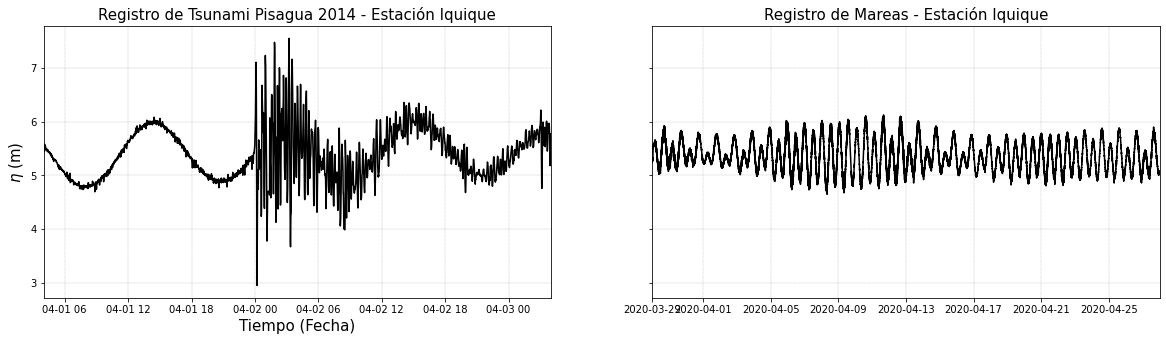

In [5]:
alto  = 5
ancho = 20

fig, ax = plt.subplots(1, 2, figsize=(ancho, alto), sharey=True)

ax[0].plot(time_tsu,tsu,'k')
ax[0].set_xlim(time_tsu[0],time_tsu[-1])
ax[0].set_xlabel('Tiempo (Fecha)',fontsize=15)
ax[0].set_ylabel('$\eta$ (m)',fontsize=15)
ax[0].set_title('Registro de Tsunami Pisagua 2014 - Estación Iquique',fontsize=15)
ax[0].grid(color='gray', linestyle='--', linewidth=0.25)


ax[1].plot(time_tide,tide,'k')
ax[1].set_xlim(time_tide[0],time_tide[-1])
ax[1].grid(color='gray', linestyle='--', linewidth=0.25)
ax[1].set_title('Registro de Mareas - Estación Iquique',fontsize=15)
#plt.plot(t,eta,'b',label='Observed '+'('+sensor_name+')')
#plt.legend()

plt.show()

In [6]:
#Interpolación del registro de Mareas
tide = tide - np.mean(tide)
start = time_tide[0]
end = start + datetime.timedelta(days=30)
dt_tide = 1/60 # [horas]
time_tide_interp = [start + datetime.timedelta(days=x*(dt_tide/24)) for x in range(0, int((24/dt_tide)*(end-start).days))]
t_total_tide = 30*24
t_tide_interp = np.arange(0,t_total_tide,dt_tide)

#Tiempo relativo al inicio del registro
time_rel_tide = np.zeros(len(tide))
for tt in range(len(tide)):
  time_rel_tide[tt] = (1.0/3600.0)*(time_tide[tt]-start).total_seconds() #en horas

tide_interp = np.interp(t_tide_interp, time_rel_tide, tide)

#Interpolación del tsunami
tsu = tsu - np.mean(tsu)
start = time_tsu[0]
end   = time_tsu[-1]
dt_tsu = 1/60 # [horas]
time_tsu_interp = [start + datetime.timedelta(days=x*(dt_tsu/24)) for x in range(0, int((24/dt_tsu)*(end-start).days))]
t_total_tsu = (1.0/3600.0)*(end-start).total_seconds() #en horas
t_tsu_interp = np.arange(0,t_total_tsu,dt_tsu)

#Tiempo relativo al inicio del registro
time_rel_tsu = np.zeros(len(tsu))
for tt in range(len(tsu)):
  time_rel_tsu[tt] = (1.0/3600.0)*(time_tsu[tt]-start).total_seconds() #en horas

tsu_interp = np.interp(t_tsu_interp, time_rel_tsu, tsu)

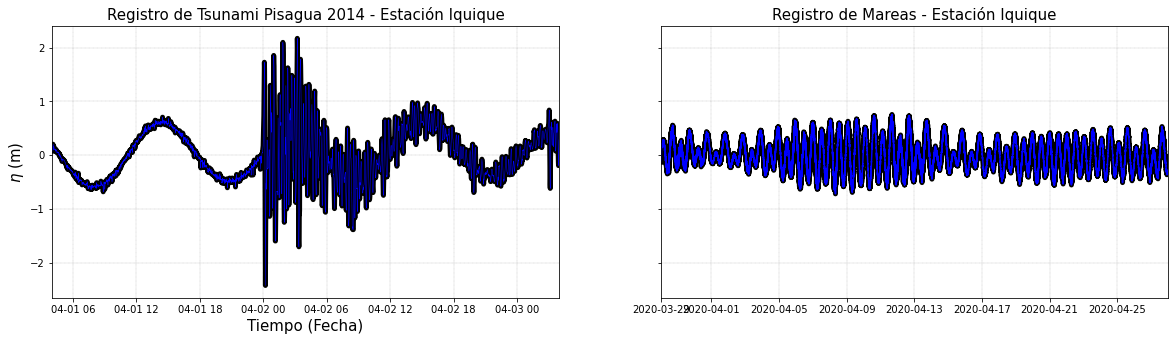

In [7]:
alto  = 5
ancho = 20

fig, ax = plt.subplots(1, 2, figsize=(ancho, alto), sharey=True)

ax[0].plot(time_tsu,tsu,'k',linewidth=5)
ax[0].plot(time_tsu_interp,tsu_interp,'b',linewidth=0.5)
ax[0].set_xlim(time_tsu[0],time_tsu[-1])
ax[0].set_xlabel('Tiempo (Fecha)',fontsize=15)
ax[0].set_ylabel('$\eta$ (m)',fontsize=15)
ax[0].set_title('Registro de Tsunami Pisagua 2014 - Estación Iquique',fontsize=15)
ax[0].grid(color='gray', linestyle='--', linewidth=0.25)


ax[1].plot(time_tide,tide,'k',linewidth=5)
ax[1].plot(time_tide_interp,tide_interp,'b')
ax[1].set_xlim(time_tide[0],time_tide[-1])
ax[1].grid(color='gray', linestyle='--', linewidth=0.25)
ax[1].set_title('Registro de Mareas - Estación Iquique',fontsize=15)
#plt.plot(t,eta,'b',label='Observed '+'('+sensor_name+')')
#plt.legend()

plt.show()

In [8]:
#Análisis Armónico de Mareas
tide_fit = t_tide(tide_interp,dt=dt_tide,stime=time_tide_interp[0],synth=0)

/content/ttide_py/ttide/t_vuf.py:51: RuntimeWarning: invalid value encountered in fmod
  v = np.fmod(np.dot(const['doodson'], astro) + const['semi'], 1)


-----------------------------------
nobs = 43200 
ngood = 43199 
record length (days) = 30.00
start time: 2020-03-29 00:00:00
rayleigh criterion = 1.0

Greenwich phase computed, no nodal corrections
x0= 0.000296  xtrend= 0
var(data)= 0.08    var(prediction)= 0.08    var(residual)= 0.00
var(prediction)/var(data) (%) = 97.8

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* MSF   0.0028219     0.0223     0.029    149.68     85.11      0.59
* 2Q1   0.0357064     0.0032     0.003    293.56     85.52       1.1
* Q1    0.0372185     0.0173     0.004    295.58     13.26        18
* O1    0.0387307     0.0808     0.004    339.57      2.93   4.3e+02
* NO1   0.0402686     0.0072     0.004     57.09     30.01       3.2
* K1    0.0417807     0.1242     0.004     27.95      1.79     1e+03
* J1    0.0432929     0.0139     0.004    103.71     16.27        15
* OO1   0.0448308     0.0092     0.004    126.69     25.48       6.6


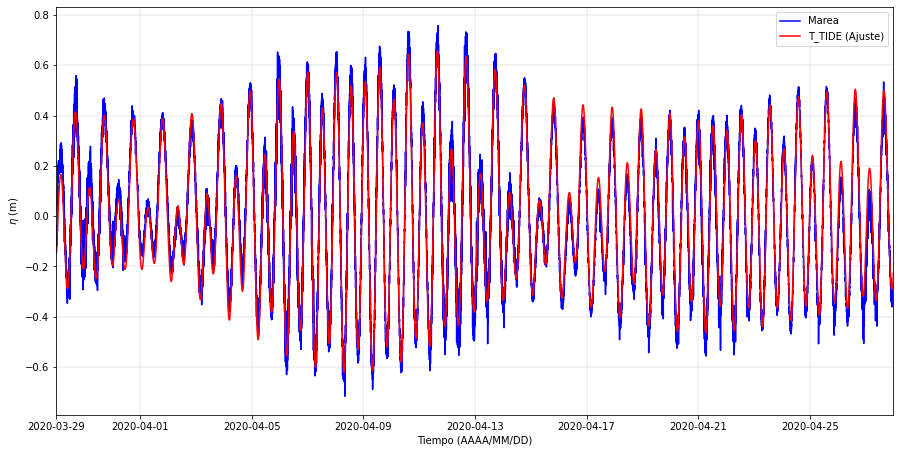

In [9]:
tide_interp_fit = tide_fit['xout'].squeeze()

alto  = 7.5
ancho = 15
fig = plt.figure(figsize=(ancho, alto))

plt.plot(time_tide_interp,tide_interp,'b',label='Marea ')
plt.plot(time_tide_interp,tide_interp_fit, 'r', label = 'T_TIDE (Ajuste)')
plt.xlim(time_tide_interp[0],time_tide_interp[-1])
plt.xlabel('Tiempo (AAAA/MM/DD)')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.25)

/content/ttide_py/ttide/t_vuf.py:51: RuntimeWarning: invalid value encountered in fmod
  v = np.fmod(np.dot(const['doodson'], astro) + const['semi'], 1)


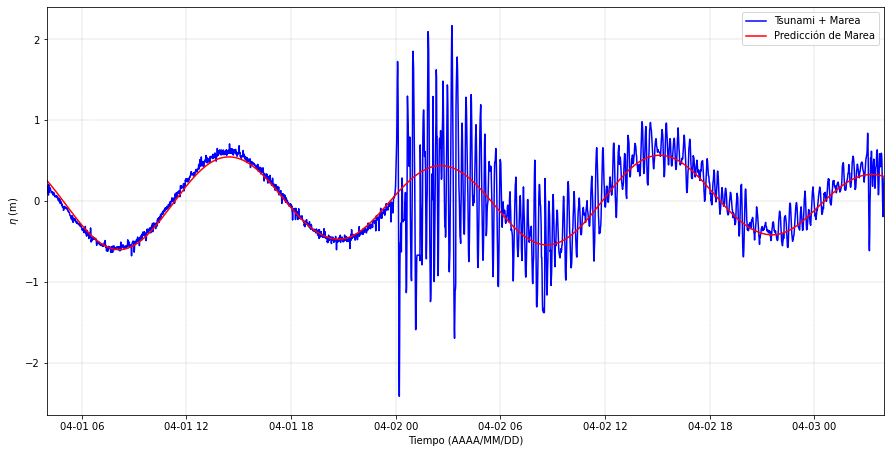

In [10]:
#Predicción de la Marea para el periodo donde ocurrió el tsunami

tide_predic = tide_fit(np.array(time_tsu_interp))
#second option
#eta_predic = t_predic(np.asarray(time_predic),tide_fit['nameu'],tide_fit['fu'],tide_fit['tidecon'])

alto  = 7.5
ancho = 15
fig = plt.figure(figsize=(ancho, alto))

plt.plot(time_tsu_interp,tsu_interp,'b',label='Tsunami + Marea')
plt.plot(time_tsu_interp,tide_predic, 'r', label = 'Predicción de Marea')
plt.xlim(time_tsu_interp[0],time_tsu_interp[-1])
plt.xlabel('Tiempo (AAAA/MM/DD)')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.25)

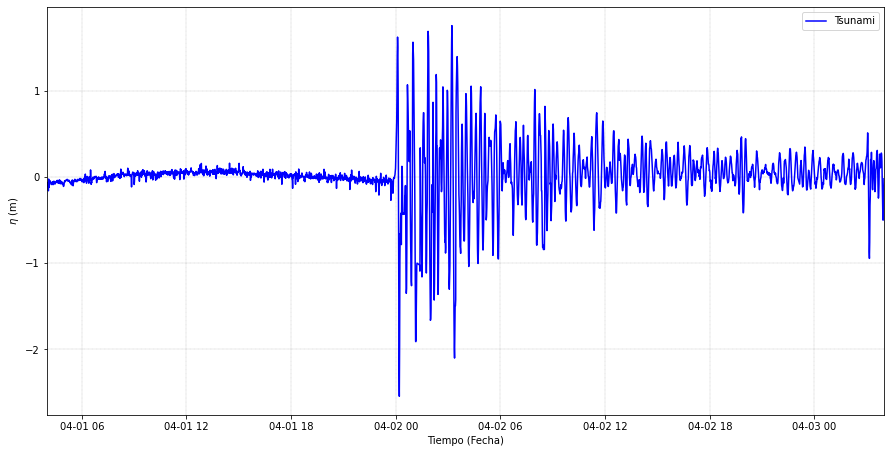

In [11]:
#Remover Marea
tsunami = tsu_interp - tide_predic

alto  = 7.5
ancho = 15
fig = plt.figure(figsize=(ancho, alto))

plt.plot(time_tsu_interp,tsunami,'b',label='Tsunami')
plt.xlim(time_tsu_interp[0],time_tsu_interp[-1])
#plt.xlim(time_tsu_interp[1000],time_tsu_interp[1500])
plt.xlabel('Tiempo (Fecha)')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.25)

Tiempo de arribo:  11.17  min


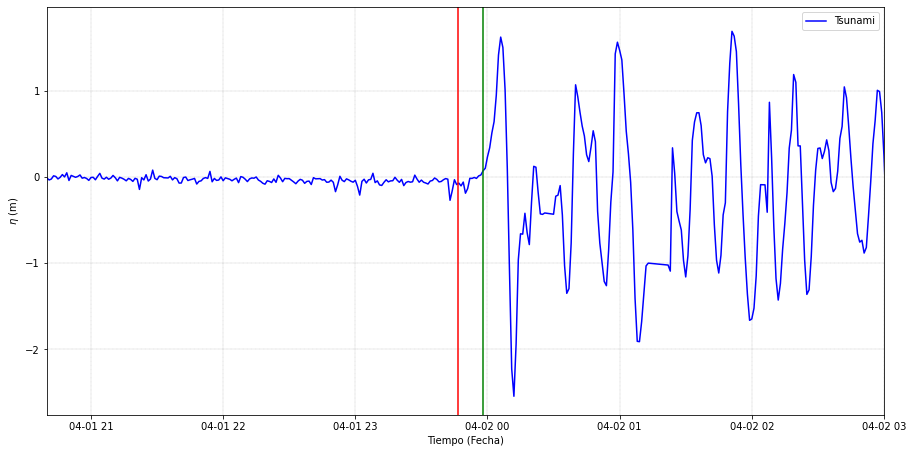

In [34]:
EQ = datetime.datetime(2014,4,1,23,46,50) #23:46:50 UTC
#time_tsu_interp
FA = datetime.datetime(2014,4,1,23,58)

alto  = 7.5
ancho = 15
fig = plt.figure(figsize=(ancho, alto))

plt.plot(time_tsu_interp,tsunami,'b',label='Tsunami')
plt.axvline(x=EQ,c='r')
plt.axvline(x=FA,c='g')
plt.xlim(time_tsu_interp[0],time_tsu_interp[-1])

plt.xlim(time_tsu_interp[1000],time_tsu_interp[-1500])

#plt.xlim(time_tsu_interp[1000],time_tsu_interp[1500])
plt.xlabel('Tiempo (Fecha)')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.25)

TA = (FA-EQ).total_seconds()/60 #tiempo de arribo en minutos
print('Tiempo de arribo: ',np.round(TA,2),' min')

15.5


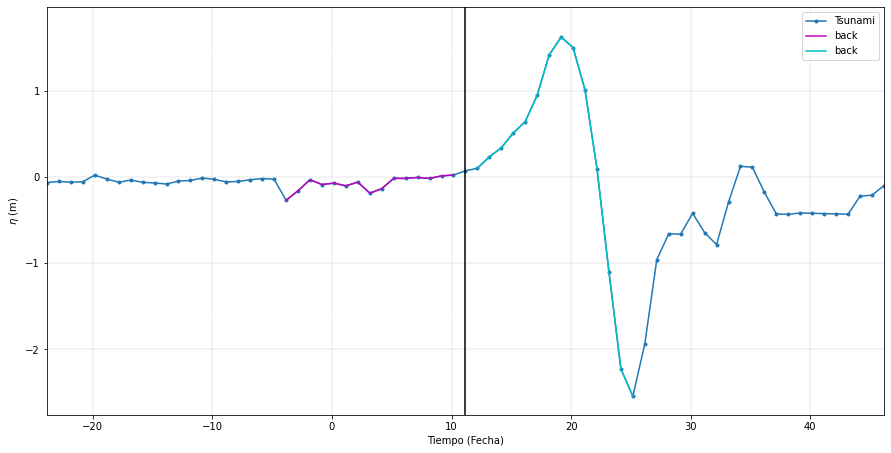

In [61]:
t_rel_EQ = np.zeros(len(time_tsu_interp))

for i in range(len(t_rel_EQ)):
  t_rel_EQ[i] = (time_tsu_interp[i] - EQ).total_seconds()/60 #en minutos

alto  = 7.5
ancho = 15
fig = plt.figure(figsize=(ancho, alto))

plt.plot(t_rel_EQ,tsunami,'.-',label='Tsunami')
plt.axvline(x=TA,c='k')
#plt.xlim(-15,3*60)

plt.xlim(-20-15+TA,15+TA+20)


ind_back = np.where((t_rel_EQ<TA) & (t_rel_EQ>-15+TA))
ind_tsu  = np.where((t_rel_EQ<15+TA) & (t_rel_EQ>TA))

plt.plot(t_rel_EQ[ind_back],tsunami[ind_back],'m',label='back')
plt.plot(t_rel_EQ[ind_tsu],tsunami[ind_tsu],'c',label='back')

plt.xlabel('Tiempo (Fecha)')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.25)

SNR = np.std(tsunami[ind_tsu])/np.std(tsunami[ind_back])
print(np.round(SNR,2))

In [56]:
t_back

(array([1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
        1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193,
        1194, 1195, 1196, 1197]),)